## Group information

Group number: 008

Kaggle team name: NaN Squad

Group members:

| Full name | Student mail | Student ID |
| --- | --- | --- |
| Henrik Skog | hjskog@stud.ntnu.no | 541913 |
| Jørgen Sandhaug | jorgeksa@stud.ntnu.no | 543919 |
| Karl Aslak Vengbo |karlav@stud.ntnu.no | 544358 |

# Install neccessary packages

In [1]:
!pip install --force-reinstall graphviz==0.18.1
!pip install autogluon matplotlib

# Config

In [1]:
# config
new_filename= "submission_1"

label = 'y'
metric = 'mean_absolute_error'
time_limit = None
presets = "experimental_zeroshot_hpo_hybrid"#'best_quality'

use_is_estimated_attr = True

drop_night_outliers = True

# to_drop = ["snow_drift:idx", "snow_density:kgm3", "wind_speed_w_1000hPa:ms", "dew_or_rime:idx", "prob_rime:p", "fresh_snow_12h:cm", "fresh_snow_24h:cm", "wind_speed_u_10m:ms", "wind_speed_v_10m:ms", "snow_melt_10min:mm", "rain_water:kgm2", "dew_point_2m:K", "precip_5min:mm", "absolute_humidity_2m:gm3", "air_density_2m:kgm3"]#, "msl_pressure:hPa", "pressure_50m:hPa",  "pressure_100m:hPa"]
to_drop = ["wind_speed_w_1000hPa:ms", "wind_speed_u_10m:ms", "wind_speed_v_10m:ms"]

excluded_model_types = ['CAT', 'XGB', 'RF']

num_stack_levels = 0
num_bag_folds = 8#8# 8
num_bag_sets = 3##20

use_tune_data = True
use_test_data = True
use_bag_holdout = True 

clip_predictions = True

# Loading and preprocessing

In [2]:
import pandas as pd
import numpy as np



import warnings
warnings.filterwarnings("ignore")


def feature_engineering(X):
    # shift columns with them by 1 hour, so that for index 16:00, we have the values from 17:00
    columns = ['clear_sky_energy_1h:J', 'diffuse_rad_1h:J', 'direct_rad_1h:J',
               'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
               'fresh_snow_3h:cm', 'fresh_snow_6h:cm']

    # Filter rows where index.minute == 0
    X_shifted = X[X.index.minute == 0][columns].copy()

    # Create a set for constant-time lookup
    index_set = set(X.index)

    # Vectorized time shifting
    one_hour = pd.Timedelta('1 hour')
    shifted_indices = X_shifted.index + one_hour
    X_shifted.loc[shifted_indices.isin(index_set)] = X.loc[shifted_indices[shifted_indices.isin(index_set)]][columns]

    # set last row to same as second last row
    X_shifted.iloc[-1] = X_shifted.iloc[-2]


    # Rename columns
    X_old_unshifted = X_shifted.copy()
    X_old_unshifted.columns = [f"{col}_not_shifted" for col in X_old_unshifted.columns]
    
    date_calc = None
    # If 'date_calc' is present, handle it
    if 'date_calc' in X.columns:
        date_calc = X[X.index.minute == 0]['date_calc']


  

    # resample to hourly
    X = X.resample('H').mean()

    # overwrite columns with shifted columns
    X[columns] = X_shifted[columns]

    if date_calc is not None:
        X['date_calc'] = date_calc

    return X




def fix_X(X, name):
    # Convert 'date_forecast' to datetime format and replace original column with 'ds'
    X['ds'] = pd.to_datetime(X['date_forecast'])
    X.drop(columns=['date_forecast'], inplace=True, errors='ignore')
    X.sort_values(by='ds', inplace=True)
    X.set_index('ds', inplace=True)

    
    X = feature_engineering(X)

    return X



def handle_features(X_train_observed, X_train_estimated, X_test, y_train):
    X_train_observed = fix_X(X_train_observed, "X_train_observed")
    X_train_estimated = fix_X(X_train_estimated, "X_train_estimated")
    X_test = fix_X(X_test, "X_test")


    y_train['ds'] = pd.to_datetime(y_train['time'])
    y_train.drop(columns=['time'], inplace=True)
    y_train.sort_values(by='ds', inplace=True)
    y_train.set_index('ds', inplace=True)

    return X_train_observed, X_train_estimated, X_test, y_train




def preprocess_data(X_train_observed, X_train_estimated, X_test, y_train, location):
    # convert to datetime
    X_train_observed, X_train_estimated, X_test, y_train = handle_features(X_train_observed, X_train_estimated, X_test, y_train)

    if use_is_estimated_attr:
        X_train_observed["is_estimated"] = 0
        X_train_estimated["is_estimated"] = 1
        X_test["is_estimated"] = 1

    # drop date_calc
    X_train_estimated.drop(columns=['date_calc'], inplace=True)
    X_test.drop(columns=['date_calc'], inplace=True)


    y_train["y"] = y_train["pv_measurement"].astype('float64')
    y_train.drop(columns=['pv_measurement'], inplace=True)
    X_train = pd.concat([X_train_observed, X_train_estimated])
    
    # clip all y values to 0 if negative
    y_train["y"] = y_train["y"].clip(lower=0)
    
    X_train = pd.merge(X_train, y_train, how="inner", left_index=True, right_index=True)


    X_train["location"] = location
    X_test["location"] = location
    
    return X_train, X_test

# Define locations
locations = ['A', 'B', 'C']

X_trains = []
X_tests = []
# Loop through locations
for loc in locations:
    print(f"Processing location {loc}...")
    # Read target training data
    y_train = pd.read_parquet(f'{loc}/train_targets.parquet')
    
    # Read estimated training data and add location feature
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    
    # Read observed training data and add location feature
    X_train_observed= pd.read_parquet(f'{loc}/X_train_observed.parquet')

    # Read estimated test data and add location feature
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocess_data(X_train_observed, X_train_estimated, X_test_estimated, y_train, loc)

    X_trains.append(X_train)
    X_tests.append(X_test)

# Concatenate all data and save to csv
X_train = pd.concat(X_trains)
X_test = pd.concat(X_tests)



Processing location A...
Processing location B...
Processing location C...


## Feature enginering

### Remove anomalies

In [3]:
import pandas as pd

def replace_streaks_with_nan(df, max_streak_length, column="y"):
    for location in df["location"].unique():
        x = df[df["location"] == location][column].copy()

        last_val = None
        streak_length = 1
        streak_indices = []
        allowed = [0]
        found_streaks = {}

        for idx in x.index:
            value = x[idx]

            if value == last_val and value not in allowed:
                streak_length += 1
                streak_indices.append(idx)
            else:
                streak_length = 1
                last_val = value
                streak_indices.clear()

            if streak_length > max_streak_length:
                found_streaks[value] = streak_length

                for streak_idx in streak_indices:
                    x[idx] = np.nan
                streak_indices.clear()  # clear after setting to NaN to avoid setting multiple times
        df.loc[df["location"] == location, column] = x

        print(f"Found streaks for location {location}: {found_streaks}")

    return df


X_train = replace_streaks_with_nan(X_train.copy(), 3, "y")

Found streaks for location A: {}
Found streaks for location B: {3.45: 28, 6.9: 7, 12.9375: 5, 13.8: 8, 276.0: 78, 18.975: 58, 0.8625: 4, 118.1625: 33, 34.5: 11, 183.7125: 1058, 87.1125: 7, 79.35: 34, 7.7625: 12, 27.6: 448, 273.41249999999997: 72, 264.78749999999997: 55, 169.05: 33, 375.1875: 56, 314.8125: 66, 76.7625: 10, 135.4125: 216, 81.9375: 202, 2.5875: 12, 81.075: 210}
Found streaks for location C: {9.8: 4, 29.400000000000002: 4, 19.6: 4}


In [4]:
# print num rows
temprows = len(X_train)
X_train.dropna(subset=['y', 'direct_rad_1h:J', 'diffuse_rad_1h:J'], inplace=True)
print("Dropped rows: ", temprows - len(X_train))


Dropped rows:  9293


In [5]:
thresh = 0.1
mask = (X_train["direct_rad_1h:J"] <= thresh) & (X_train["diffuse_rad_1h:J"] <= thresh) & (X_train["y"] >= 0.1)

if drop_night_outliers:
    X_train.loc[mask, "y"] = np.nan

In [6]:
temprows = len(X_train)
X_train.dropna(subset=['y', 'direct_rad_1h:J', 'diffuse_rad_1h:J'], inplace=True)
print("Dropped rows: ", temprows - len(X_train))

Dropped rows:  1876


In [7]:
X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)

X_train.to_csv('X_train_raw.csv', index=True)
X_test.to_csv('X_test_raw.csv', index=True)

In [8]:
def split_and_shuffle_data(input_data, num_bins, frac1):
    # Validate the input fraction
    if frac1 < 0 or frac1 > 1:
        raise ValueError("frac1 must be between 0 and 1.")
    
    if frac1==1:
        return input_data, pd.DataFrame()

    # Calculate the fraction for the second output set
    frac2 = 1 - frac1
    
    # Calculate bin size
    bin_size = len(input_data) // num_bins

    # Initialize empty DataFrames for output
    output_data1 = pd.DataFrame()
    output_data2 = pd.DataFrame()

    for i in range(num_bins):
        # Shuffle the data in the current bin
        np.random.seed(i)
        current_bin = input_data.iloc[i * bin_size: (i + 1) * bin_size].sample(frac=1)
        
        # Calculate the sizes for each output set
        size1 = int(len(current_bin) * frac1)
        
        # Split and append to output DataFrames
        output_data1 = pd.concat([output_data1, current_bin.iloc[:size1]])
        output_data2 = pd.concat([output_data2, current_bin.iloc[size1:]])

    # Shuffle and split the remaining data
    remaining_data = input_data.iloc[num_bins * bin_size:].sample(frac=1)

    remaining_size1 = int(len(remaining_data) * frac1)
    
    output_data1 = pd.concat([output_data1, remaining_data.iloc[:remaining_size1]])
    output_data2 = pd.concat([output_data2, remaining_data.iloc[remaining_size1:]])

    return output_data1, output_data2


In [9]:
from autogluon.tabular import TabularDataset, TabularPredictor
data = TabularDataset('X_train_raw.csv')
data['ds'] = pd.to_datetime(data['ds'])
data = data.sort_values(by='ds')

split_time = pd.to_datetime("2022-10-28 22:00:00")
train_set = TabularDataset(data[data["ds"] < split_time])
estimated_set = TabularDataset(data[data["ds"] >= split_time]) # only estimated

test_set = pd.DataFrame()
tune_set = pd.DataFrame()
new_train_set = pd.DataFrame()

for location in locations:
    loc_data = data[data["location"] == location]
    num_train_rows = len(loc_data)
    
    tune_rows = 1500.0 # 2500.0
    if use_test_data:
        tune_rows = 1880.0#max(3000.0, len(estimated_set[estimated_set["location"] == location]))

    holdout_frac = max(0.01, min(0.1, tune_rows / num_train_rows)) * num_train_rows / len(estimated_set[estimated_set["location"] == location])

    # shuffle and split data
    loc_tune_set, loc_new_train_set = split_and_shuffle_data(estimated_set[estimated_set['location'] == location], 40, holdout_frac)

    new_train_set = pd.concat([new_train_set, loc_new_train_set])

    if use_test_data:
        loc_test_set, loc_tune_set = split_and_shuffle_data(loc_tune_set, 40, 0.2)
        test_set = pd.concat([test_set, loc_test_set])

    tune_set = pd.concat([tune_set, loc_tune_set])

# add rest to train_set
train_set = pd.concat([train_set, new_train_set])
tuning_data = tune_set
if use_test_data:
    test_data = test_set

train_data = train_set

train_data = TabularDataset(train_data)
tuning_data = TabularDataset(tuning_data)

if use_test_data:
    test_data = TabularDataset(test_data)

In [ ]:
# log transform y
train_data["y"] = np.log(train_data["y"] + 1e-8)
tuning_data["y"] = np.log(tuning_data["y"] + 1e-8)
test_data["y"] = np.log(test_data["y"] + 1e-8)

# Modeling

In [11]:
predictors = [None, None, None]

In [12]:
def fit_predictor_for_location(loc):
    # All of these hyperparameters have been found by experimenting with some standard parameters in AutoGluon, and then only using the best ones for each location to make the train time shorter
    r118 = {'extra_trees': True, 'feature_fraction': 0.7832570544199176, 'learning_rate': 0.021720607471727896, 'min_data_in_leaf': 3, 'num_leaves': 21, 'ag_args': {'name_suffix': '_r118', 'priority': 17}}
    r51 = {'bs': 1024, 'emb_drop': 0.6046989241462619, 'epochs': 48, 'layers': [200, 100, 50], 'lr': 0.00775309042164966, 'ps': 0.09244767444160731, 'ag_args': {'name_suffix': '_r51', 'priority': 12}}
    r145 = {'bs': 128, 'emb_drop': 0.44339037504795686, 'epochs': 31, 'layers': [400, 200, 100], 'lr': 0.008615195908919904, 'ps': 0.19220253419114286, 'ag_args': {'name_suffix': '_r145', 'priority': 9}}
    lgbmXT = {'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}
    if loc == "A":
        hyperparameters = {
            'NN_TORCH': {},
            'GBM': [lgbmXT, r118, 'GBMLarge'],#, r_118],
            'FASTAI': [r51],
        }
    elif loc == "B":
        hyperparameters = {
            'NN_TORCH': {},
            'GBM': [r118],
            'FASTAI': [{}, r145],
        }

    elif loc == "C":
        hyperparameters = {
            'NN_TORCH': {},
	        'KNN': [{'weights': 'uniform', 'ag_args': {'name_suffix': 'Unif'}}],
            'GBM': [r118],
            'FASTAI': [r51],
        }


    predictor = TabularPredictor(
        label=label, 
        eval_metric=metric, 
        path=f"AutogluonModels/{new_filename}_{loc}", 
    ).fit(
        train_data=train_data[train_data["location"] == loc].drop(columns=["ds"]),
        time_limit=time_limit, 
        presets=presets, 
        num_stack_levels=num_stack_levels,
        num_bag_folds=num_bag_folds,
        num_bag_sets=num_bag_sets,
        tuning_data=tuning_data[tuning_data["location"] == loc].reset_index(drop=True).drop(columns=["ds"]),
        hyperparameters = hyperparameters,
        use_bag_holdout=use_bag_holdout,
        #excluded_model_types=excluded_model_types
    )

    # evaluate on test data
    if use_test_data:
        t = test_data[test_data["location"] == loc]
        perf = predictor.evaluate(t)
        print("Evaluation on test data:")
        print(perf[predictor.eval_metric.name])

    return predictor

loc = "A"
predictors[0] = fit_predictor_for_location(loc)



Presets specified: ['experimental_zeroshot_hpo_hybrid']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=3
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/submission_136_A/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   99.51 GB / 494.38 GB (20.1%)
Train Data Rows:    30934
Train Data Columns: 44
Tuning Data Rows:    1485
Tuning Data Columns: 44
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, 0.0, 673.41535, 1195.24)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You 

Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    3331.4 MB
	Train Data (Original)  Memory Usage: 13.03 MB (0.4% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 3): ['elevation:m', 'snow_drift:idx', 'location']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of feature

[1000]	valid_set's l1: 188.903
[2000]	valid_set's l1: 183.38
[3000]	valid_set's l1: 180.745
[4000]	valid_set's l1: 178.855
[5000]	valid_set's l1: 177.036
[6000]	valid_set's l1: 176.178
[7000]	valid_set's l1: 175.372
[8000]	valid_set's l1: 174.791
[9000]	valid_set's l1: 174.317
[10000]	valid_set's l1: 173.968
[1000]	valid_set's l1: 195.036
[2000]	valid_set's l1: 190.396
[3000]	valid_set's l1: 187.398
[4000]	valid_set's l1: 185.562
[5000]	valid_set's l1: 184.402
[6000]	valid_set's l1: 183.498
[7000]	valid_set's l1: 182.975
[8000]	valid_set's l1: 182.6
[9000]	valid_set's l1: 182.308
[10000]	valid_set's l1: 182.089
[1000]	valid_set's l1: 174.756
[2000]	valid_set's l1: 170.021
[3000]	valid_set's l1: 167.451
[4000]	valid_set's l1: 166.491
[5000]	valid_set's l1: 165.668
[6000]	valid_set's l1: 164.958
[7000]	valid_set's l1: 164.495
[8000]	valid_set's l1: 164.319
[9000]	valid_set's l1: 164.064
[10000]	valid_set's l1: 163.91
[1000]	valid_set's l1: 185.905
[2000]	valid_set's l1: 180.669
[3000]	va

	-86.158	 = Validation score   (-mean_absolute_error)
	3506.39s	 = Training   runtime
	16.76s	 = Validation runtime
Fitting model: NeuralNetTorch_BAG_L1 ...
	Fitting 24 child models (S1F1 - S3F8) | Fitting with SequentialLocalFoldFittingStrategy
	-87.4034	 = Validation score   (-mean_absolute_error)
	738.13s	 = Training   runtime
	0.42s	 = Validation runtime
Fitting model: LightGBM_r118_BAG_L1 ...
	Fitting 24 child models (S1F1 - S3F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 196.904
[2000]	valid_set's l1: 190.607
[3000]	valid_set's l1: 187.091
[4000]	valid_set's l1: 184.168
[5000]	valid_set's l1: 182.265
[6000]	valid_set's l1: 180.313
[7000]	valid_set's l1: 179.262
[8000]	valid_set's l1: 178.294
[9000]	valid_set's l1: 177.417
[10000]	valid_set's l1: 176.686
[1000]	valid_set's l1: 203.298
[2000]	valid_set's l1: 196.232
[3000]	valid_set's l1: 192.207
[4000]	valid_set's l1: 189.201
[5000]	valid_set's l1: 186.588
[6000]	valid_set's l1: 184.734
[7000]	valid_set's l1: 183.29
[8000]	valid_set's l1: 182.073
[9000]	valid_set's l1: 181.009
[10000]	valid_set's l1: 180.123
[1000]	valid_set's l1: 184.004
[2000]	valid_set's l1: 177.114
[3000]	valid_set's l1: 173.096
[4000]	valid_set's l1: 170.176
[5000]	valid_set's l1: 168.127
[6000]	valid_set's l1: 166.408
[7000]	valid_set's l1: 165.167
[8000]	valid_set's l1: 164.149
[9000]	valid_set's l1: 163.541
[10000]	valid_set's l1: 163.015
[1000]	valid_set's l1: 196.856
[2000]	valid_set's l1: 190.083
[3000]

	-85.2617	 = Validation score   (-mean_absolute_error)
	1744.63s	 = Training   runtime
	11.4s	 = Validation runtime
Fitting model: NeuralNetFastAI_r51_BAG_L1 ...
	Fitting 24 child models (S1F1 - S3F8) | Fitting with SequentialLocalFoldFittingStrategy
	-95.69	 = Validation score   (-mean_absolute_error)
	273.05s	 = Training   runtime
	0.31s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ...
	Fitting 24 child models (S1F1 - S3F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 180.725
[2000]	valid_set's l1: 179.262
[3000]	valid_set's l1: 178.983
[4000]	valid_set's l1: 178.905
[5000]	valid_set's l1: 178.876
[6000]	valid_set's l1: 178.871
[7000]	valid_set's l1: 178.868
[8000]	valid_set's l1: 178.867
[9000]	valid_set's l1: 178.866
[10000]	valid_set's l1: 178.866


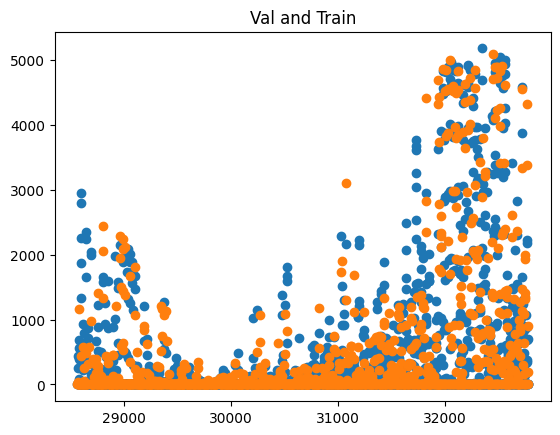

                        model  score_test  score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           LightGBMXT_BAG_L1 -105.629299 -86.171125        2.757117     267.977811   66.673744                 2.757117              267.977811          66.673744            1       True          1
1         WeightedEnsemble_L2 -105.742732 -82.247352       15.061079     835.773022  458.526718                 0.004030                0.000701           0.214789            2       True          6
2  NeuralNetFastAI_r51_BAG_L1 -106.247964 -95.666327        0.383407       0.937461   38.080469                 0.383407                0.937461          38.080469            1       True          4
3        LightGBM_r118_BAG_L1 -106.870624 -85.259916        2.342607     188.234109   51.846491                 2.342607              188.234109          51.846491            1       True          3
4    

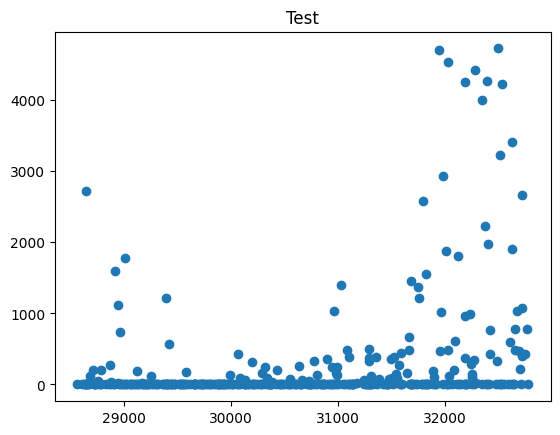

In [ ]:
import matplotlib.pyplot as plt
leaderboards = [None, None, None]
def leaderboard_for_location(i, loc):
    plt.scatter(train_data[(train_data["location"] == loc) & (train_data["is_estimated"]==True)]["y"].index, train_data[(train_data["location"] == loc) & (train_data["is_estimated"]==True)]["y"])
    plt.scatter(tuning_data[tuning_data["location"] == loc]["y"].index, tuning_data[tuning_data["location"] == loc]["y"])
    plt.title("Val and Train")
    plt.show()

    if use_test_data:
        lb = predictors[i].leaderboard(test_data[test_data["location"] == loc])
        lb["location"] = loc
        plt.scatter(test_data[test_data["location"] == loc]["y"].index, test_data[test_data["location"] == loc]["y"])
        plt.title("Test")
        
        return lb
    
    return pd.DataFrame()

leaderboards[0] = leaderboard_for_location(0, loc)

Presets specified: ['experimental_zeroshot_hpo_hybrid']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=3
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/submission_142_B/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Debian 5.10.197-1 (2023-09-29)
Disk Space Avail:   137.93 GB / 315.93 GB (43.7%)
Train Data Rows:    27377
Train Data Columns: 44
Tuning Data Rows:    1485
Tuning Data Columns: 44
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1152.3, -0.0, 98.11625, 206.48535)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 

Evaluation on test data:
-10.7894783641021


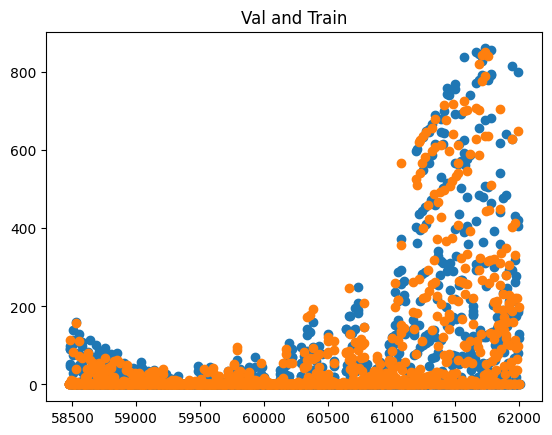

                         model  score_test  score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0          WeightedEnsemble_L2  -10.789478 -12.324207        4.397277     162.457627  361.852653                 0.003336                0.000642           0.168811            2       True          5
1         LightGBM_r118_BAG_L1  -11.008035 -12.921242        2.348640     156.671800   47.358682                 2.348640              156.671800          47.358682            1       True          3
2        NeuralNetTorch_BAG_L1  -11.182017 -12.836698        0.574365       1.147147  168.137105                 0.574365                1.147147         168.137105            1       True          2
3       NeuralNetFastAI_BAG_L1  -12.273773 -13.198685        0.498963       1.545790   44.273498                 0.498963                1.545790          44.273498            1       True          1


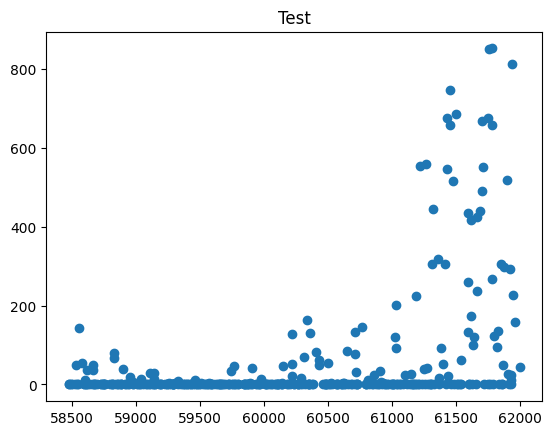

In [ ]:
loc = "B"
predictors[1] = fit_predictor_for_location(loc)
leaderboards[1] = leaderboard_for_location(1, loc)

Presets specified: ['experimental_zeroshot_hpo_hybrid']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=3
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/submission_142_C/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Debian 5.10.197-1 (2023-09-29)
Disk Space Avail:   137.39 GB / 315.93 GB (43.5%)
Train Data Rows:    24073
Train Data Columns: 44
Tuning Data Rows:    1481
Tuning Data Columns: 44
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (999.6, -0.0, 80.87539, 169.67845)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclas

Evaluation on test data:
-11.875635142630587


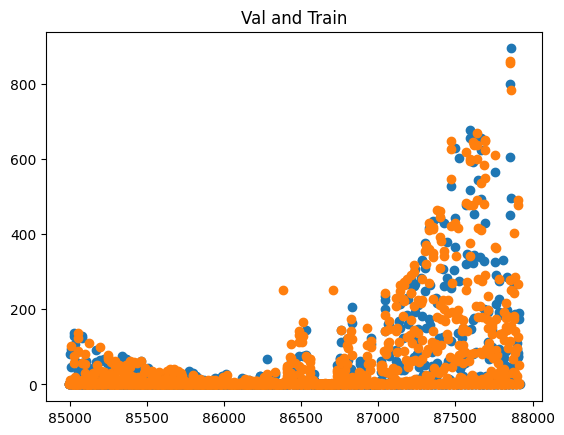

                        model  score_test  score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         WeightedEnsemble_L2  -11.875635 -11.118753        3.301615     122.859288  196.134156                 0.003131                0.000628           0.173273            2       True          5
1        LightGBM_r118_BAG_L1  -11.977019 -11.213239        2.352773     120.538184   46.121330                 2.352773              120.538184          46.121330            1       True          3
2  NeuralNetFastAI_r51_BAG_L1  -12.945380 -12.489102        0.377565       0.844247   30.014023                 0.377565                0.844247          30.014023            1       True          4
3       NeuralNetTorch_BAG_L1  -13.236768 -13.391358        0.546498       1.076832  119.800254                 0.546498                1.076832         119.800254            1       True          2
4    

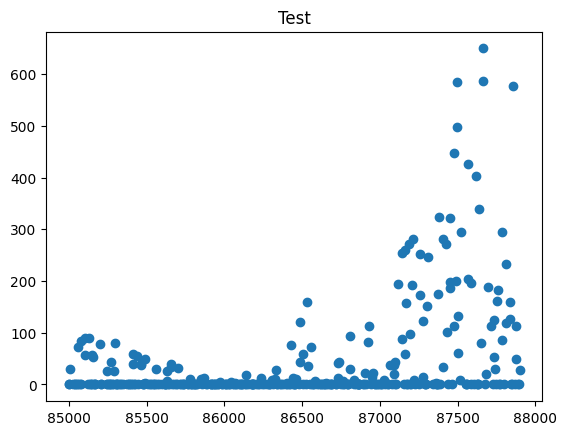

In [ ]:
loc = "C"
predictors[2] = fit_predictor_for_location(loc)
leaderboards[2] = leaderboard_for_location(2, loc)

In [ ]:
# save leaderboards to csv
pd.concat(leaderboards).to_csv(f"leaderboard_{new_filename}.csv")


for i in range(len(predictors)):
    print(f"Predictor {i}:")
    print(predictors[i].info()["model_info"]["WeightedEnsemble_L2"]["children_info"]["S1F1"]["model_weights"])

Predictor 0:
{'LightGBMXT_BAG_L1': 0.2823529411764706, 'NeuralNetTorch_BAG_L1': 0.35294117647058826, 'LightGBM_r118_BAG_L1': 0.16470588235294117, 'LightGBMLarge_BAG_L1': 0.2}
Predictor 1:
{'NeuralNetFastAI_BAG_L1': 0.14893617021276595, 'NeuralNetTorch_BAG_L1': 0.2872340425531915, 'LightGBM_r118_BAG_L1': 0.3829787234042553, 'NeuralNetFastAI_r145_BAG_L1': 0.18085106382978725}
Predictor 2:
{'KNeighborsUnif_BAG_L1': 0.036585365853658534, 'NeuralNetTorch_BAG_L1': 0.012195121951219513, 'LightGBM_r118_BAG_L1': 0.8170731707317073, 'NeuralNetFastAI_r51_BAG_L1': 0.13414634146341464}


# Submit

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

future_test_data = TabularDataset('X_test_raw.csv')
future_test_data["ds"] = pd.to_datetime(future_test_data["ds"])

Loaded data from: X_test_raw.csv | Columns = 45 / 45 | Rows = 4608 -> 4608


In [ ]:
test_ids = TabularDataset('test.csv')
test_ids["time"] = pd.to_datetime(test_ids["time"])
# merge test_data with test_ids
future_test_data_merged = pd.merge(future_test_data, test_ids, how="inner", right_on=["time", "location"], left_on=["ds", "location"])

Loaded data from: test.csv | Columns = 4 / 4 | Rows = 2160 -> 2160


In [ ]:
# predict, grouped by location
predictions = []
location_map = {
    "A": 0,
    "B": 1,
    "C": 2
}
for loc, group in future_test_data.groupby('location'):
    i = location_map[loc]
    subset = future_test_data_merged[future_test_data_merged["location"] == loc].reset_index(drop=True)
    pred = predictors[i].predict(subset)
    pred = np.exp(pred) - 1e-8
    subset["prediction"] = pred
    predictions.append(subset)

    # get past predictions
    #tuning_data.loc[tuning_data["location"] == loc, "prediction"] =  predictors[i].predict(tuning_data[tuning_data["location"] == loc])
    if use_test_data:
        # get predictions for local test_data
        test_data.loc[test_data["location"] == loc, "prediction"] =  np.exp(predictors[i].predict(test_data[test_data["location"] == loc])) - 1e-8

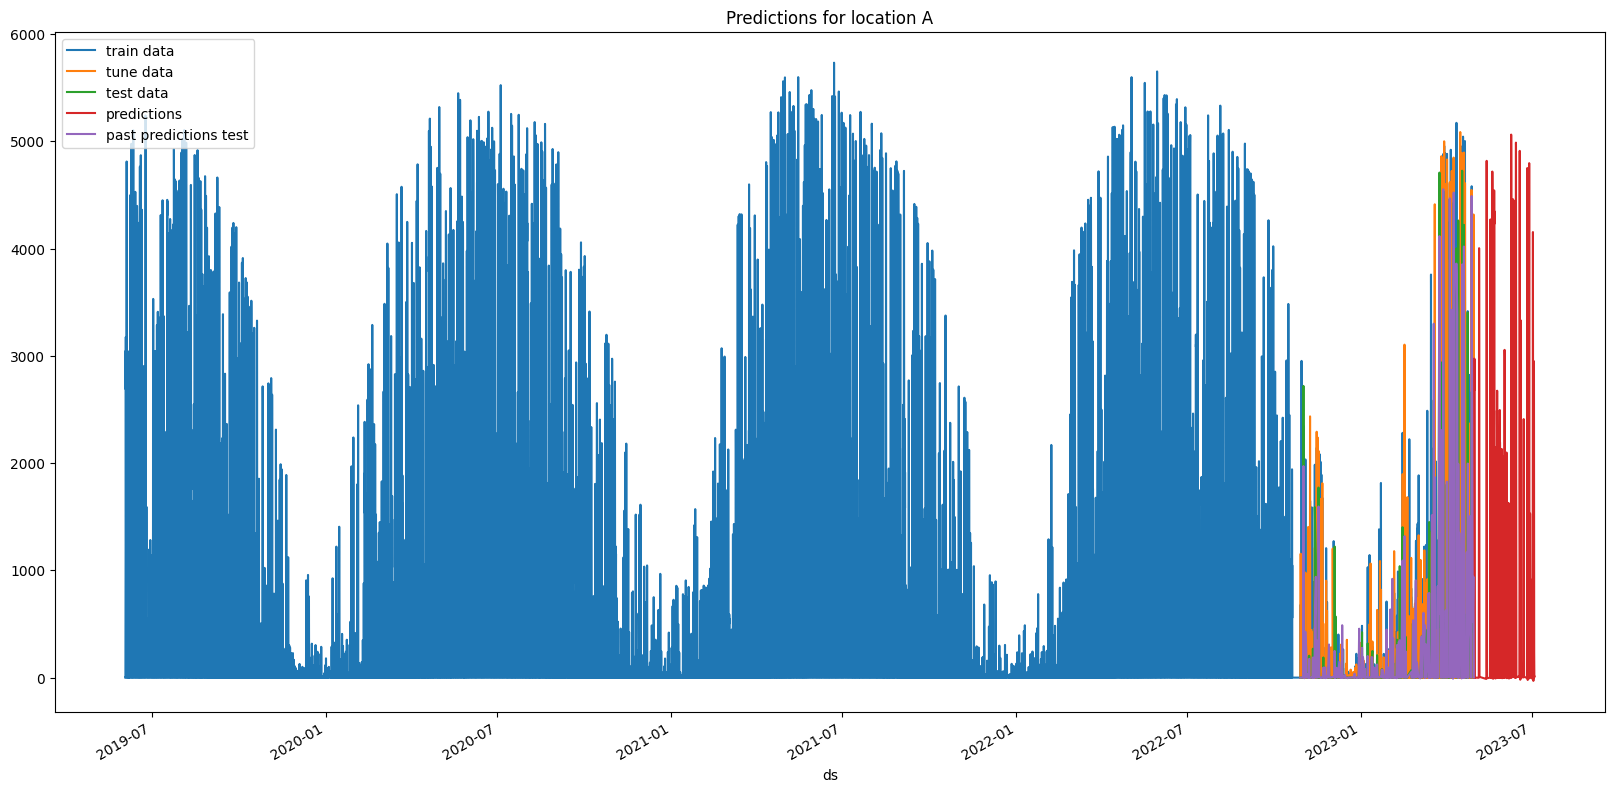

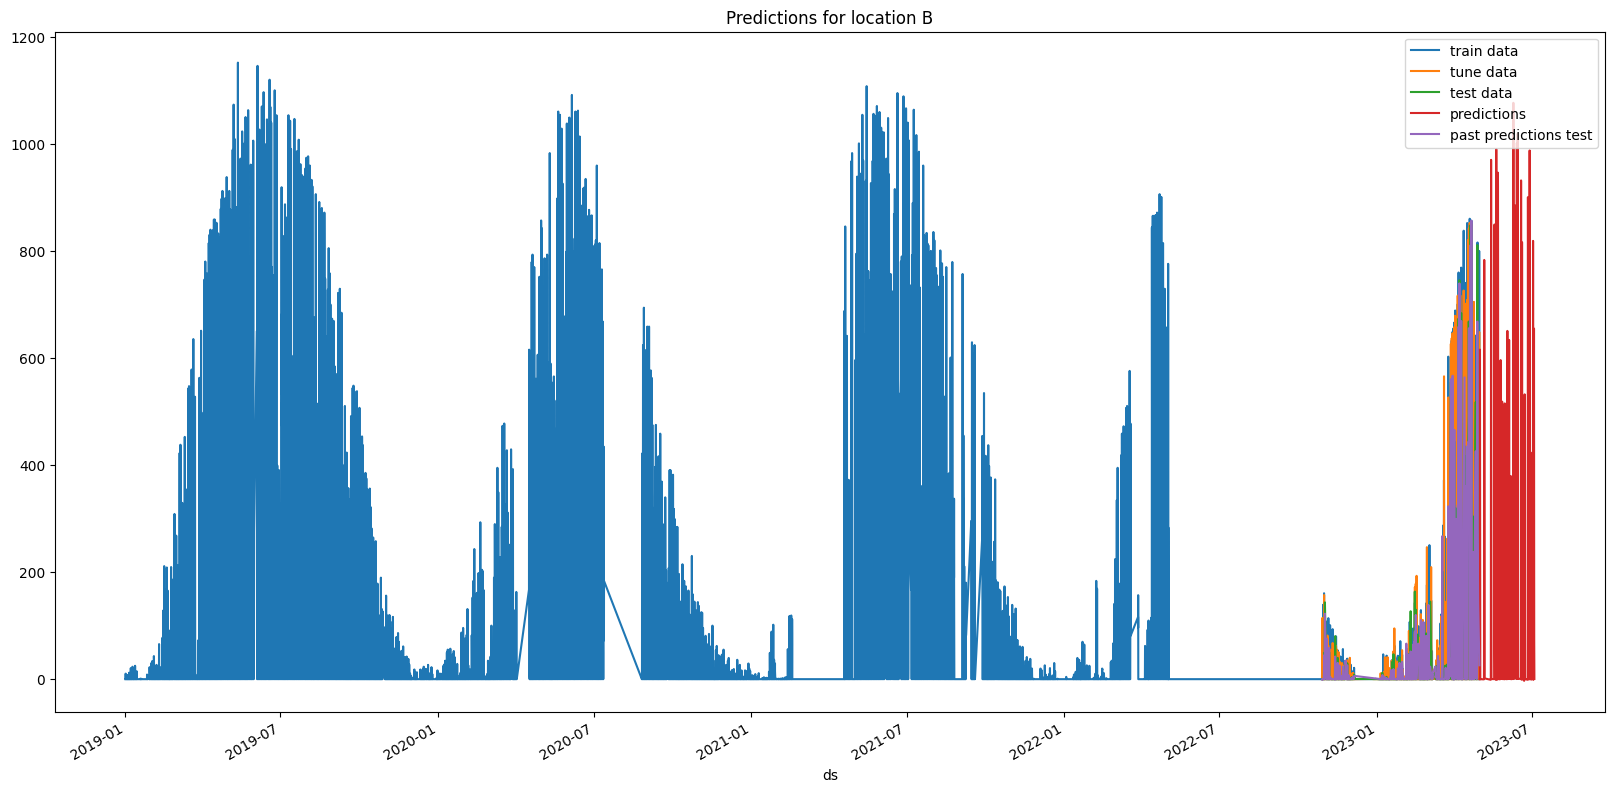

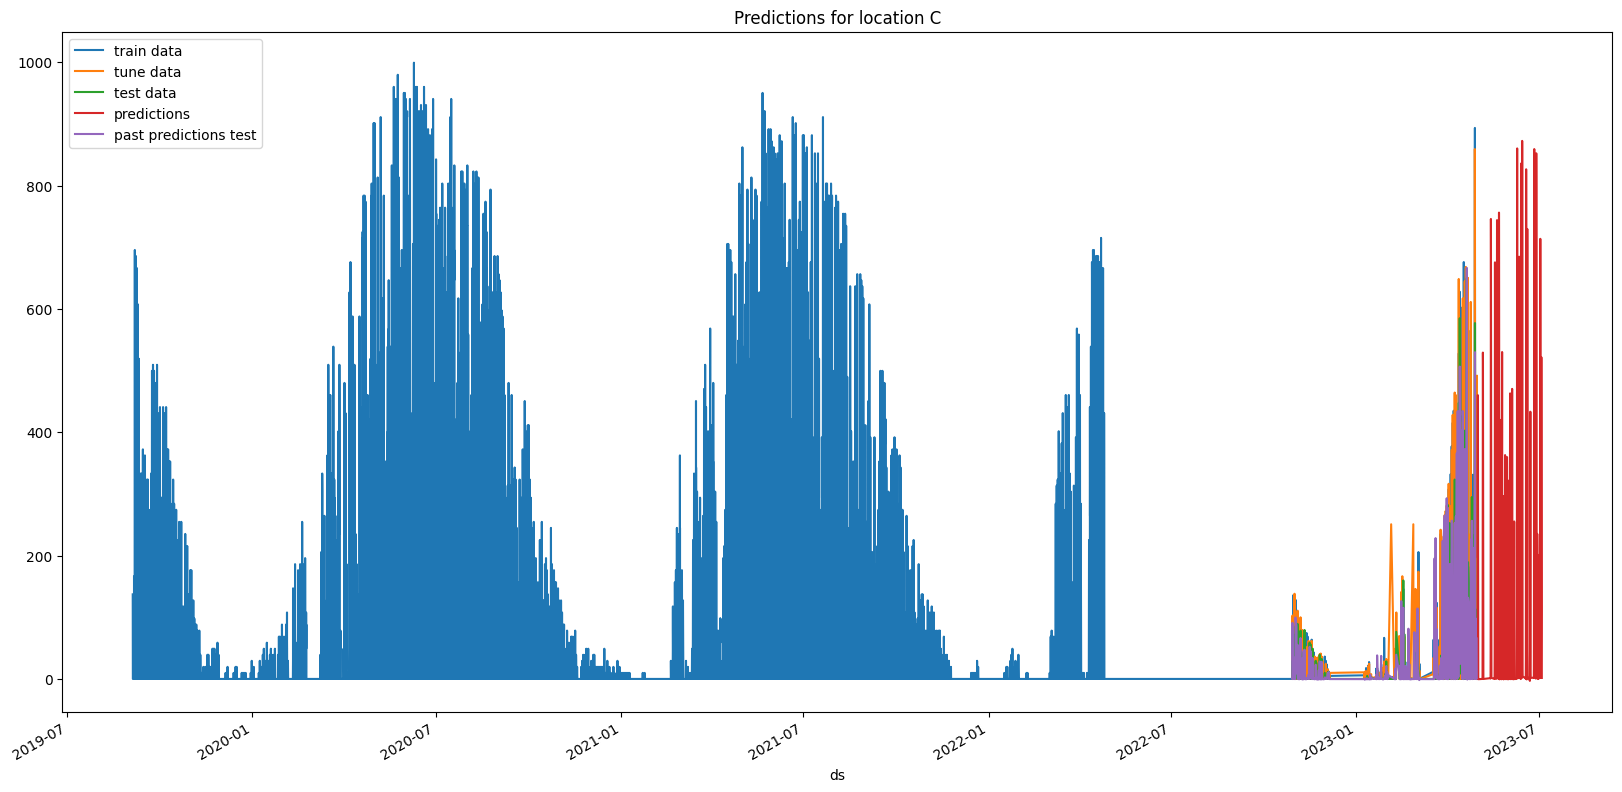

In [ ]:
for loc, idx in location_map.items():
    fig, ax = plt.subplots(figsize=(20, 10))
    # plot train data
    train_data[train_data["location"]==loc].plot(x='ds', y='y', ax=ax, label="train data")
    tuning_data[tuning_data["location"]==loc].plot(x='ds', y='y', ax=ax, label="tune data")
    if use_test_data:
        test_data[test_data["location"]==loc].plot(x='ds', y='y', ax=ax, label="test data")

    # plot predictions
    predictions[idx].plot(x='ds', y='prediction', ax=ax, label="predictions")

    # plot past predictions
    #tuning_data[tuning_data["location"]==loc].plot(x='ds', y='prediction', ax=ax, label="past predictions tune")
    if use_test_data:
        test_data[test_data["location"]==loc].plot(x='ds', y='prediction', ax=ax, label="past predictions test")


    ax.set_title(f"Predictions for location {loc}")

In [ ]:
temp_predictions = [prediction.copy() for prediction in predictions]
if clip_predictions:
    # clip predictions smaller than 0 to 0
    for pred in temp_predictions:
        # print smallest prediction
        print("Smallest prediction:", pred["prediction"].min())
        pred.loc[pred["prediction"] < 0, "prediction"] = 0
        print("Smallest prediction after clipping:", pred["prediction"].min())


# concatenate predictions
submissions_df = pd.concat(temp_predictions)
submissions_df = submissions_df[["id", "prediction"]]
submissions_df

Smallest prediction: -30.471474
Smallest prediction after clipping: 0.0
Smallest prediction: -3.0752246
Smallest prediction after clipping: 0.0
Smallest prediction: -3.1478677
Smallest prediction after clipping: 0.0


,id,prediction
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,30.471388
4,4,309.942200
...,...,...
715,2155,62.359646
716,2156,35.705055
717,2157,8.107715
718,2158,1.970510


In [ ]:
# Save the submission
print(f"Saving submission to {new_filename}.csv")
submissions_df.to_csv(f"{new_filename}.csv", index=False)

Saving submission to submissions/submission_142.csv


In [ ]:
# feature importance
print("\033[1m" + "Calculating feature importance for location A..." + "\033[0m")
print(predictors[0].feature_importance(feature_stage="original", data=test_data[test_data["location"] == "A"], time_limit=60*10))
print("\033[1m" + "Calculating feature importance for location B..." + "\033[0m")
print(predictors[1].feature_importance(feature_stage="original", data=test_data[test_data["location"] == "B"], time_limit=60*10))
print("\033[1m" + "Calculating feature importance for location C..." + "\033[0m")
print(predictors[2].feature_importance(feature_stage="original", data=test_data[test_data["location"] == "C"], time_limit=60*10))

These features in provided data are not utilized by the predictor and will be ignored: ['ds', 'elevation:m', 'snow_drift:idx', 'location', 'prediction']
Computing feature importance via permutation shuffling for 41 features using 361 rows with 10 shuffle sets... Time limit: 600s...


Calculating feature importance for location A...


	6299.62s	= Expected runtime (629.96s per shuffle set)
	556.69s	= Actual runtime (Completed 8 of 10 shuffle sets) (Early stopping due to lack of time...)
These features in provided data are not utilized by the predictor and will be ignored: ['ds', 'elevation:m', 'location', 'prediction']
Computing feature importance via permutation shuffling for 42 features using 361 rows with 10 shuffle sets... Time limit: 600s...


                                importance     stddev       p_value  n  \
direct_rad:W                    104.069145   5.795764  1.502413e-10  8   
clear_sky_rad:W                  68.575522  10.068412  1.265379e-07  8   
diffuse_rad:W                    62.134230   7.578349  3.516900e-08  8   
sun_elevation:d                  25.859155   5.634662  1.873632e-06  8   
sun_azimuth:d                    24.264215  10.749928  1.864269e-04  8   
clear_sky_energy_1h:J            18.317073   7.712776  1.365413e-04  8   
direct_rad_1h:J                  16.850952   3.857918  2.614651e-06  8   
effective_cloud_cover:p          12.321047   2.588230  1.462885e-06  8   
total_cloud_cover:p              12.293495   2.463435  1.062471e-06  8   
diffuse_rad_1h:J                  9.097221   3.379883  6.246524e-05  8   
relative_humidity_1000hPa:p       8.966096   2.066613  2.735902e-06  8   
snow_water:kgm2                   7.251352   3.935467  6.186022e-04  8   
ceiling_height_agl:m              5.72

	1866.73s	= Expected runtime (186.67s per shuffle set)
	338.5s	= Actual runtime (Completed 10 of 10 shuffle sets)
These features in provided data are not utilized by the predictor and will be ignored: ['ds', 'elevation:m', 'snow_drift:idx', 'location', 'prediction']
Computing feature importance via permutation shuffling for 41 features using 360 rows with 10 shuffle sets... Time limit: 600s...


                                importance    stddev       p_value   n  \
clear_sky_rad:W                  31.587960  2.610076  1.409745e-11  10   
direct_rad:W                     19.005209  1.239041  1.686452e-12  10   
diffuse_rad:W                    14.643005  1.777099  4.356866e-10  10   
sun_elevation:d                  10.150755  1.139892  2.183115e-10  10   
clear_sky_energy_1h:J             7.924555  1.267501  5.025189e-09  10   
sun_azimuth:d                     7.634168  1.078358  1.675814e-09  10   
direct_rad_1h:J                   3.855799  0.595161  3.671306e-09  10   
effective_cloud_cover:p           3.348848  0.568381  8.473403e-09  10   
diffuse_rad_1h:J                  3.307861  0.845782  2.975928e-07  10   
fresh_snow_24h:cm                 2.204943  0.612355  6.011762e-07  10   
is_in_shadow:idx                  1.485250  0.173928  3.170873e-10  10   
relative_humidity_1000hPa:p       1.408372  0.381177  4.831119e-07  10   
cloud_base_agl:m                  1.38

	1469.61s	= Expected runtime (146.96s per shuffle set)
	167.27s	= Actual runtime (Completed 10 of 10 shuffle sets)


                                  importance    stddev       p_value   n  \
clear_sky_rad:W                 9.492532e+00  0.799178  1.666848e-11  10   
clear_sky_energy_1h:J           7.382851e+00  0.668056  3.177582e-11  10   
direct_rad:W                    5.329617e+00  0.649175  4.500538e-10  10   
direct_rad_1h:J                 3.410787e+00  0.449938  9.139202e-10  10   
sun_elevation:d                 3.150492e+00  0.428365  1.195200e-09  10   
sun_azimuth:d                   3.138013e+00  0.618942  3.159672e-08  10   
diffuse_rad:W                   2.284770e+00  0.412072  1.444585e-08  10   
diffuse_rad_1h:J                1.737366e+00  0.211993  4.571480e-10  10   
t_1000hPa:K                     1.443522e+00  0.944473  4.648883e-04  10   
air_density_2m:kgm3             1.236523e+00  0.564241  3.417133e-05  10   
effective_cloud_cover:p         1.085109e+00  0.249225  1.184326e-07  10   
is_day:idx                      1.073634e+00  0.118328  1.847534e-10  10   
fresh_snow_2